In [1]:
import torch
from torch import nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchmetrics.classification import BinaryAccuracy

## Device Afgnostic Code

In [2]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Wed Jan 29 01:22:48 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0  On |                  N/A |
| N/A   41C    P8              N/A /  16W |    139MiB /  4096MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Make the dataset and split it in 80-20 fromat (Tensor)

In [4]:
# Setup the hyperparameter
N_SAMPLE = 1000
RANDOM_SEED = 42

X_moon, y_moon = make_moons(n_samples=N_SAMPLE, noise=0.07, random_state=RANDOM_SEED)

X_moon[:10], y_moon[:10]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483],
        [ 0.59906425, -0.28977331],
        [ 0.29009023, -0.2046885 ],
        [-0.03826868,  0.45942924],
        [ 1.61377123, -0.2939697 ],
        [ 0.693337  ,  0.82781911]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

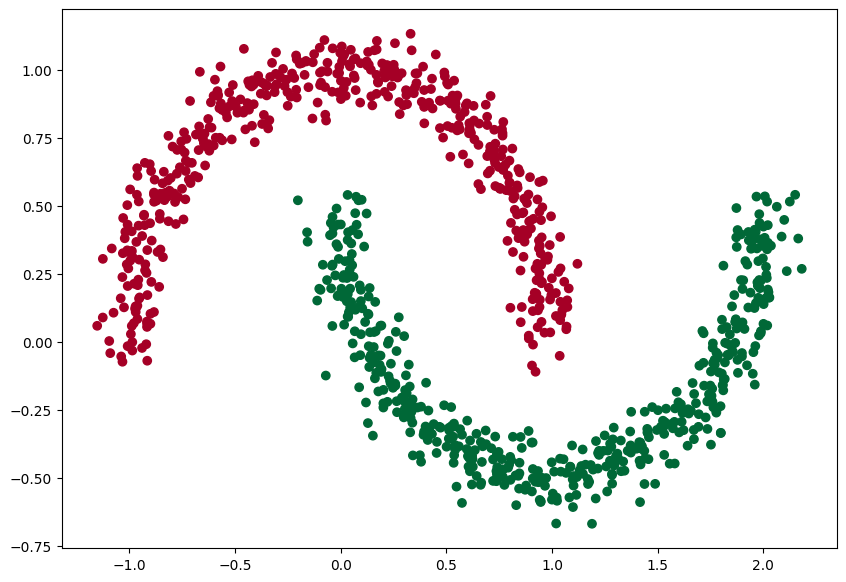

In [5]:
# Visualize the data
plt.figure(figsize=(10,7))
plt.scatter(X_moon[:, 0], 
            X_moon[:, 1], 
            c=y_moon, 
            cmap=plt.cm.RdYlGn)
plt.show()

In [6]:
# Make the data into tensor
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.float)

In [7]:
#Split the dataset into train (80%) & test (20%)
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, 
                                                                         y_moon, 
                                                                         test_size=0.2, 
                                                                         random_state=RANDOM_SEED)


In [8]:
# Print the train and test data features and labels shape
print(f"The length of train data features: {len(X_moon_train)} & The shape of test data feature: {len(X_moon_test)}")
print(f"The length of train data labels: {len(y_moon_train)} & The shape of test data feature: {len(y_moon_test)}")

The length of train data features: 800 & The shape of test data feature: 200
The length of train data labels: 800 & The shape of test data feature: 200


## Build the Model by subclassing `nn.Module`

In [9]:
# Setup Model 
class MakeMoonModelV0(nn.Module):
    def __init__(self, input_features:int, output_features:int, hidden_units:int):
        """Initialize of the binary classification model

        Args:
          input_features (int): Number of the features
          output_features (int): Number of the output
          hidden_units (int): Number of hidden units. (default: 8)
        
        Returns:

        Example:
        """
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_stack(x)


# Create model instance and transfer to the device
model_0 = MakeMoonModelV0(input_features=2, 
                          output_features=1, 
                          hidden_units=8).to(device)

model_0

MakeMoonModelV0(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

## Loss function, Optimizer & Accuracy

In [10]:
# loss function and optimizer and metric (BinaryAccuracy)
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)
accuracy = BinaryAccuracy().to(device)

## Train the model and Test

In [11]:
# setup the manual seed
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

epochs = 1000

# Send the data to the device
X_moon_train, y_moon_train = X_moon_train.to(device), y_moon_train.to(device)
X_moon_test, y_moon_test = X_moon_test.to(device), y_moon_test.to(device)

for epoch in range(epochs):
    model_0.train()

    train_moon_logits = model_0(X_moon_train).squeeze()
    train_moon_preds = torch.round(torch.sigmoid(train_moon_logits))

    train_loss = loss_fn(train_moon_logits, y_moon_train)
    train_accuracy = accuracy(train_moon_preds, y_moon_train) * 100

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    ## Testing
    model_0.eval()
    with torch.inference_mode():
        test_moon_logits = model_0(X_moon_test).squeeze()
        test_moon_preds = torch.round(torch.sigmoid(test_moon_logits))

        test_loss = loss_fn(test_moon_logits, y_moon_test)
        test_accuracy = accuracy(test_moon_preds, y_moon_test) * 100
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_accuracy:.2f}%")


Epoch: 0 | Train Loss: 0.6956, Train Acc: 50.00% | Test loss: 0.6950, Test acc: 50.00%
Epoch: 10 | Train Loss: 0.6864, Train Acc: 50.00% | Test loss: 0.6862, Test acc: 50.00%
Epoch: 20 | Train Loss: 0.6802, Train Acc: 78.25% | Test loss: 0.6808, Test acc: 78.50%
Epoch: 30 | Train Loss: 0.6720, Train Acc: 74.88% | Test loss: 0.6734, Test acc: 68.50%
Epoch: 40 | Train Loss: 0.6605, Train Acc: 71.62% | Test loss: 0.6629, Test acc: 64.50%
Epoch: 50 | Train Loss: 0.6444, Train Acc: 71.88% | Test loss: 0.6483, Test acc: 68.00%
Epoch: 60 | Train Loss: 0.6227, Train Acc: 72.25% | Test loss: 0.6288, Test acc: 69.00%
Epoch: 70 | Train Loss: 0.5958, Train Acc: 73.50% | Test loss: 0.6047, Test acc: 70.00%
Epoch: 80 | Train Loss: 0.5660, Train Acc: 74.62% | Test loss: 0.5778, Test acc: 71.50%
Epoch: 90 | Train Loss: 0.5357, Train Acc: 76.25% | Test loss: 0.5498, Test acc: 72.50%
Epoch: 100 | Train Loss: 0.5064, Train Acc: 78.50% | Test loss: 0.5224, Test acc: 74.00%
Epoch: 110 | Train Loss: 0.4791,

In [12]:
# Predict some
model_0.eval()
with torch.inference_mode():
    y_pred_logits = model_0(X_moon_test).squeeze()
    y_pred = torch.round(torch.sigmoid(y_pred_logits))
y_pred[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0.], device='cuda:0')

In [13]:
y_moon_test[:10]

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')

## Plot the Predictions

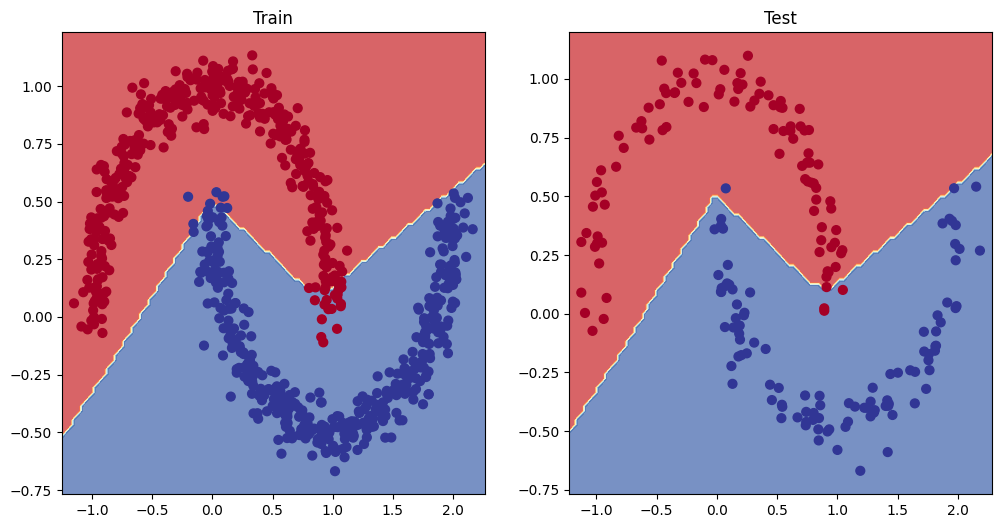

In [14]:
from helper_functions import plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_moon_train, y_moon_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_moon_test, y_moon_test) 